In [2]:
library(Seurat)
library(maftools)
options(stringsAsFactors = F)
#setwd('G:/3D2/wes2')
setwd('/home/wyh/scdata/WES/')

Attaching SeuratObject

Attaching sp



In [ ]:
## https://www.jieandze1314.com/post/cnposts/237/

# data preparation

## Map the clinical patient name and standardalized name

In [8]:
laml <- annovarToMaf(annovar = "annovar_merge.vcf", 
                     refBuild = 'hg38',
                     tsbCol = 'Tumor_Sample_Barcode', 
                     table = 'refGene',
                     MAFobj = T)

-Reading annovar files
-Processing Exonic variants
--Adding Variant_Classification
--Parsing aa-change
-Processing Non-exonic variants
--Adding Variant_Classification
-Adding Variant_Type
Finished in 23.9s elapsed (27.9s cpu) 


In [ ]:
# 这一步的目的是修改病人的表格信息，手动调整了一些

patient_info = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)

patient_index = as.numeric(substr(unique(laml@data$Tumor_Sample_Barcode),1,6))
sample_name_df = data.frame(Tumor_Sample = unique(laml@data$Tumor_Sample_Barcode),patient_index = patient_index)
sample_name_df$NewSample.ID = NA
rownames(sample_name_df) = sample_name_df$Tumor_Sample
MAT_sample = c()
MAT_sample_list = list()
for(isample in sample_name_df$Tumor_Sample){
  NewSample.ID = patient_info[patient_info$patient.index==sample_name_df[isample,2],"NewSample.ID"]
  if(length(NewSample.ID)==1){
    sample_name_df[isample,'NewSample.ID'] = NewSample.ID
  }else if(grepl("INV",isample)){
    sample_name_df[isample,'NewSample.ID'] = NewSample.ID[grepl("LI",NewSample.ID)]
  }else if(grepl("MAT",isample)){
    MAT_sample = c(MAT_sample,isample)
    MAT_sample_list[[length(MAT_sample_list)+1]] = NewSample.ID
  }else{
    sample_name_df[isample,'NewSample.ID'] = NewSample.ID[grepl("P$",NewSample.ID)]
  }
}
names(MAT_sample_list) = MAT_sample
write.csv(sample_name_df,"./sample_name_df.csv")

#sample_name_df = merge(sample_name_df,patient_info)
    
# 手动调整了一下

sample_name_df = read.csv("./sample_name_df.csv",row.names = 1)
rownames(sample_name_df) = sample_name_df$Tumor_Sample
write.table(sample_name_df[,c(2,1)],"file_rename.csv")

## Change default patient name in VCF files and add clinical data

In [175]:
patient_info = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)

In [252]:
sample_name_df = read.csv("./file_rename.csv",row.names = 1)
sample_name_df = merge(sample_name_df,patient_info)
rownames(sample_name_df) = sample_name_df$NewSample.ID
sample_name_df$Tumor_Sample_Barcode = sample_name_df$NewSample.ID
## annovar
laml <- annovarToMaf(annovar = "annovar_merge_20_3_0015_005.vcf", 
                             refBuild = 'hg38',
                             tsbCol = 'Tumor_Sample_Barcode', 
                             table = 'refGene',
                             MAFobj = T)

laml@data$Tumor_Sample_Barcode = factor(sample_name_df[laml@data$Tumor_Sample_Barcode,"NewSample.ID"])
laml@variants.per.sample$Tumor_Sample_Barcode = sample_name_df[laml@variants.per.sample$Tumor_Sample_Barcode,"NewSample.ID"]
laml@variant.type.summary$Tumor_Sample_Barcode = sample_name_df[laml@variant.type.summary$Tumor_Sample_Barcode,"NewSample.ID"]
laml@variant.classification.summary$Tumor_Sample_Barcode = sample_name_df[laml@variant.classification.summary$Tumor_Sample_Barcode,"NewSample.ID"]
laml@maf.silent$Tumor_Sample_Barcode = sample_name_df[laml@maf.silent$Tumor_Sample_Barcode,"NewSample.ID"]
laml@clinical.data = data.table::data.table(sample_name_df[unique(as.character(laml@data$Tumor_Sample_Barcode)),])

saveRDS(laml,"laml_filter_20_3_0015_005.RDS")


-Reading annovar files
-Processing Exonic variants
--Adding Variant_Classification
--Parsing aa-change
-Processing Non-exonic variants
--Adding Variant_Classification
-Adding Variant_Type
Finished in 6.533s elapsed (6.958s cpu) 


# mutation analysis

## acquire mutation matrix

In [289]:
laml = readRDS("laml_filter_20_3_0015_005.RDS")

In [290]:
hyper_sample = as.data.frame(laml@variants.per.sample)
hyper_sample = hyper_sample[,1][hyper_sample[,2]>1000]
hyper_sample

[1] "GBC_016_P" "GBC_059_P" "GBC_080_P"

In [288]:
sample_name_df = read.csv("./file_rename.csv",row.names = 1)
no_mutation_sample = setdiff(sample_name_df$NewSample.ID,laml@clinical.data$Tumor_Sample_Barcode)
no_mutation_sample

[1] "GBC_049_P"

In [283]:
laml_filter = subsetMaf(laml,mafObj = TRUE,
                 tsb = laml@clinical.data$NewSample.ID[!(laml@clinical.data$NewSample.ID %in% hyper_sample)])

In [284]:
# laml_P = subsetMaf(laml_filter,mafObj = TRUE,clinQuery = "Tumors.for.scRNA.seq.short %in% 'P'")
# laml_P = subsetMaf(laml_P,mafObj = TRUE,clinQuery = "histological.type.short %in% 'adeno'")

-subsetting by clinical data..

--75 samples meet the clinical query

-subsetting by clinical data..

--64 samples meet the clinical query



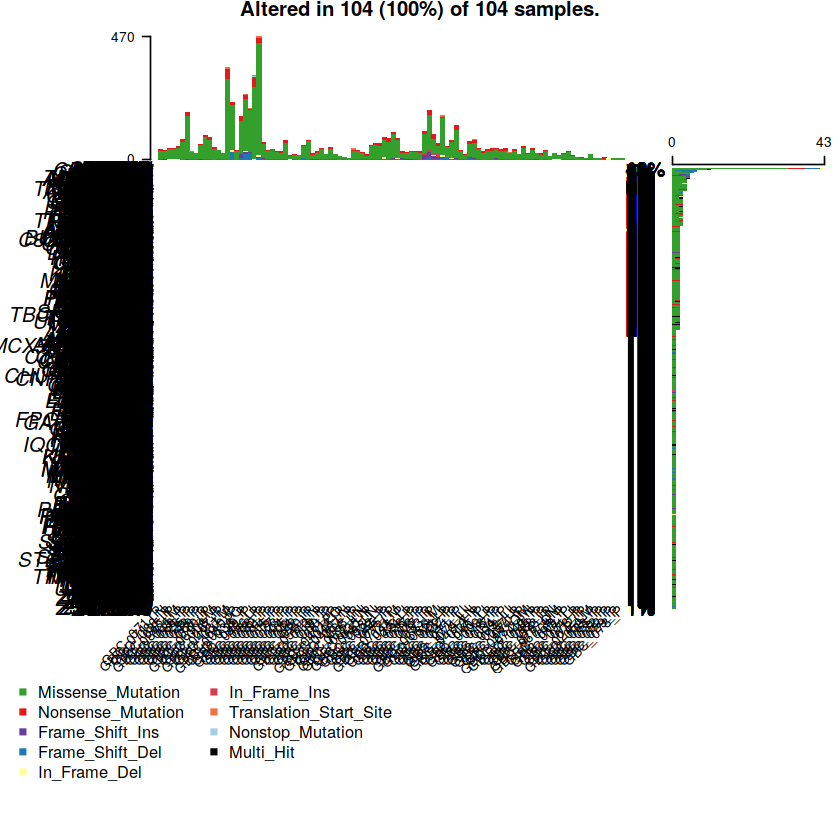

In [244]:
oncoplot(maf = laml_filter,
         fontSize = 1,
         removeNonMutated = FALSE,
         top = length(unique(laml_filter@data$Hugo_Symbol)),
         cohortSize = length(unique(laml_filter@data$Tumor_Sample_Barcode)),
         #genes = unique(c(gene28,gene51,gene52)),
         #genes = lung,
         #sampleOrder =  c("LC28-Tumor" ,"LC28-LCA","LC51-Tumor" ,"LC51-LCA","LC52-Tumor" ,"LC52-LCA"),
         # sampleOrder = laml@clinical.data$Tumor_Sample_Barcode,
         showTumorSampleBarcodes = T,
         borderCol = "white",
         #colors = color_maf,
         gene_mar = 10,
         bgCol  = "white",
         barcodeSrt=45,
         writeMatrix = TRUE)

In [245]:
onco_matrix_all = read.csv("./onco_matrix.txt",header = T, check.names = F, sep = "\t")

In [247]:
onco_matrix_all$GBC_049_P = ""
write.csv(onco_matrix_all,"./onco_matrix_105_patient.csv")

In [57]:
onco_matrix_all = read.csv("onco_matrix_105_patient.csv",row.names = 1)

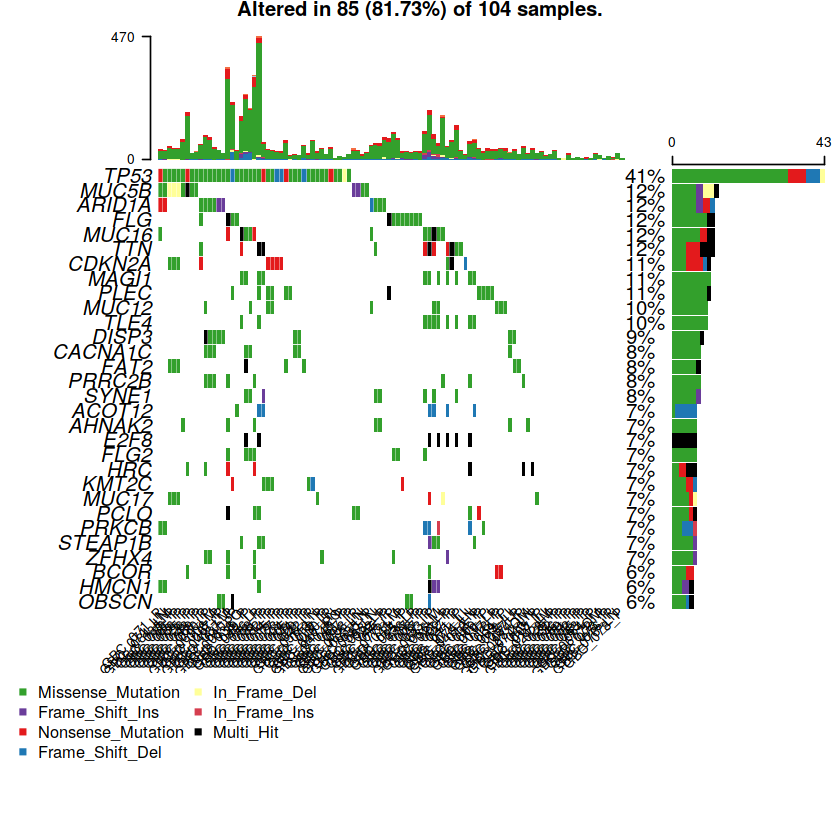

In [291]:
oncoplot(maf = laml_filter,
         fontSize = 1,
         removeNonMutated = FALSE,
         top = 30,
         cohortSize = length(unique(laml_filter@data$Tumor_Sample_Barcode)),
         #genes = unique(c(gene28,gene51,gene52)),
         #genes = lung,
         #sampleOrder =  c("LC28-Tumor" ,"LC28-LCA","LC51-Tumor" ,"LC51-LCA","LC52-Tumor" ,"LC52-LCA"),
         # sampleOrder = laml@clinical.data$Tumor_Sample_Barcode,
         showTumorSampleBarcodes = T,
         borderCol = "white",
         #colors = color_maf,
         gene_mar = 10,
         bgCol  = "white",
         barcodeSrt=45,
         writeMatrix = TRUE)

In [292]:
onco_matrix_P = read.csv("./onco_matrix.txt",header = T, check.names = F, sep = "\t")
# add the samples which are 0
onco_matrix_P[,setdiff(unique(as.data.frame(laml@clinical.data)[,1]),colnames(onco_matrix_P))] = ""
# add the samples with no mutation
onco_matrix_P[,no_mutation_sample] = ""
# remove the samples with hyper mutation
hyper_sample = as.data.frame(laml@variants.per.sample)
hyper_sample = hyper_sample[,1][hyper_sample[,2]>1000]
onco_matrix_P = onco_matrix_P[,setdiff(colnames(onco_matrix_P),hyper_sample)]
dim(onco_matrix_P)

[1]  30 105

In [183]:
write.csv(onco_matrix_P,"./onco_matrix_filter.csv")

In [71]:
variants_number = as.data.frame(laml@variants.per.sample)
variants_number[108,] = c("GBC_049_P",0)
rownames(variants_number) = variants_number[,1]

In [72]:
variants_number_left = variants_number[colnames(onco_matrix_P),]

In [74]:
write.csv(variants_number_left,'./variants_number.csv')

In [2]:
variants_number_left = read.csv("./variants_number.csv",row.names = 1)

###  top mutation in other article

In [ ]:
### Genomic ERBB2/ ERBB3 mutations promote PD-L1-mediated immune escape in gallbladder cancer: a whole-exome sequencing analysis mutation_gene_Li2018，里面包含2014年的数据
### Integrative molecular characterisation of gallbladder cancer reveals micro-environment-associated subtypes Nepal2021
## Li2018 are curated manually

In [206]:
wes = read.csv("../WES/public/Nepal2021.txt",header = TRUE,sep = "\t")
gene_list = list()
for(ipatient in unique(wes$Tumor.ID)){
  gene_list[[ipatient]] = unique(wes[wes$Tumor.ID==ipatient,'HUGO.symbol'])
  if(sum(duplicated(wes[wes$Tumor.ID==ipatient,'HUGO.symbol']))!=0){
    print(ipatient)
  }
}

gene_list1 = unlist(gene_list)
gene_list1 = as.data.frame.array(table(gene_list1))
gene_list1$name = rownames(gene_list1)
gene_list1 = gene_list1[order(-gene_list1$`table(gene_list1)`),]
gene_list1

[1] "GBC_0315Tumor"
[1] "GBC_0448Tumor"
[1] "GBC_0551Tumor"
[1] "GBC_0584Tumor"
[1] "GBC_0687Tumor"
[1] "GBC_0719Tumor"
[1] "GBC_0824Tumor"
[1] "GBC_0859Tumor"
[1] "GBC_0899Tumor"
[1] "GBC_0973Tumor"
[1] "GBC_1040Tumor"
[1] "GBC_1070Tumor"
[1] "GBC_1166Tumor"
[1] "GBC_1341Tumor"
[1] "GBC_1404Tumor"
[1] "GBC_1456Tumor"
[1] "GBC_1483Tumor"
[1] "GBC_1609Tumor"
[1] "GBC_1740Tumor"
[1] "GBC_1785Tumor"
[1] "GBC_1829Tumor"
[1] "GBC_1916Tumor"
[1] "GBC_3120Tumor"
[1] "GBC_A000024Tumor"
[1] "GBC_A000033Tumor"
[1] "GBC_A000034Tumor"
[1] "GBC_A000076Tumor"
[1] "GBC_A000156Tumor"
[1] "GBC_A000186Tumor"
[1] "GBC_A000191Tumor"
[1] "HDG01Tumor"
[1] "HDG02Tumor"
[1] "HDG04Tumor"
[1] "HDG05Tumor"
[1] "HDG06Tumor"
[1] "HDG07Tumor"
[1] "HDG08Tumor"
[1] "HDG10Tumor"
[1] "HDG16Tumor"
[1] "HDG17Tumor"
[1] "HDG22Tumor"
[1] "HDG23Tumor"
[1] "HDG27Tumor"
[1] "HDG29Tumor"
[1] "HDG34Tumor"
[1] "HDG35Tumor"
[1] "HDG38Tumor"


,table(gene_list1),name
,<int>,<chr>
TP53,27,TP53
CTBP2,7,CTBP2
MYO15A,7,MYO15A
CRIPAK,6,CRIPAK
DNAH17,6,DNAH17
ELF3,6,ELF3
XIRP2,6,XIRP2
AATK,5,AATK
ARID2,5,ARID2


In [ ]:
mutation_gene_Zhou2023 = row.names(read.csv("./onco_matrix_filter.csv",row.names = 1))[1:30]

In [207]:
top_gene_mutation_rate = data.frame(row.names = mutation_gene_Zhou2023,Nepal2021 = gene_list1[mutation_gene_Zhou2023,1]/93)

In [210]:
write.csv(top_gene_mutation_rate,"../WES/public/top_gene_mutation_rateV2.csv")

### oncoplot 
https://blog.csdn.net/weixin_41368414/article/details/125174493

In [184]:
library(maftools)
library(ComplexHeatmap)
library(reshape2)

In [293]:
matMut <- read.csv("onco_matrix_filter.csv",row.names = 1)

In [188]:
laml = readRDS("laml_filter_20_3_0015_005.RDS")
pdata <- getClinicalData(laml)

In [170]:
column_title <- "Altered in 91 of 108 samples"

In [189]:
matMut[matMut == "In-frame"] = "In_frame"
matMuttmp = matMut
matMuttmp$gene = row.names(matMuttmp)
mat_long <- melt(matMuttmp, id.vars = "gene", value.name = "Variant_Classification")
levels(factor(mat_long$Variant_Classification))
## [1] ""           "In_frame"   "Missense"   "Multi_Hit"  "Truncating"


[1] ""                  "Frame_Shift_Del"   "Frame_Shift_Ins"  
[4] "In_Frame_Del"      "In_Frame_Ins"      "Missense_Mutation"
[7] "Multi_Hit"         "Nonsense_Mutation"

In [190]:
freq_mut = as.data.frame.array(table(mat_long$Variant_Classification))
freq = freq_mut[2:8,]
names(freq) = rownames(freq_mut)[2:8]
freq = sort(freq,decreasing = TRUE)
freq

Missense_Mutation         Multi_Hit Nonsense_Mutation   Frame_Shift_Del 
              209                26                26                17 
  Frame_Shift_Ins      In_Frame_Del      In_Frame_Ins 
                9                 5                 1

In [191]:
pdata <- subset(pdata, pdata$Tumor_Sample_Barcode %in% colnames(matMut))
pdata = as.data.frame(pdata)
rownames(pdata) = pdata$NewSample.ID
pdata <- pdata[colnames(matMut),]
dim(pdata)

[1] 105  36

In [192]:
pdata$metastasis.type[pdata$metastasis.type=="P_LI"] = "P"
pdata$metastasis.type = factor(pdata$metastasis.type,levels = c("P","P_LN","P_LM","NA"))

# pdata = data.frame(metastasis.type = pdata$metastasis.type,sample_name = pdata$NewSample.ID)
# col_metastasis.type = col1[8:10]
# names(col_metastasis.type) = c("P","P_LN","P_LM")

In [193]:
color = read.csv("../figures/palette_celltype_outputV2.csv",row.names = 1)

In [196]:

#col_metastasis.type = c(P = "red",P_LN = "blue",P_LM = "yellow")
col <- c(Frame_Shift_Del = "purple", Frame_Shift_Ins = "orange", In_Frame_Del = "black", In_Frame_Ins = "blue",
         Missense_Mutation = "red",Multi_Hit = "yellow",Nonsense_Mutation = "blue")

col <- c(Missense_Mutation = "#d62728",Multi_Hit = "#17becf",In_Frame_Del = "#e377c2",Nonsense_Mutation = "#aa40fc",Frame_Shift_Del = "#aec7e8",
         Frame_Shift_Ins = "#279e68",  In_Frame_Ins = "#1f77b4")

# col <- color[1:7]

# col = col1[1:7]
names(col) = c("Missense_Mutation", "Multi_Hit"  , "In_Frame_Del",     
               "Nonsense_Mutation","Frame_Shift_Del", "Frame_Shift_Ins" , "In_Frame_Ins")
alter_fun <- list(
  background = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = "white", col = NA))
  },
  Frame_Shift_Del = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Frame_Shift_Del"], col = NA))
  },
  Frame_Shift_Ins = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"),  
              gp = gpar(fill = col["Frame_Shift_Ins"], col = NA))
  },
  In_Frame_Del = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["In_Frame_Del"], col = NA))
  },
  In_Frame_Ins = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["In_Frame_Ins"], col = NA))
  },
  Missense_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Missense_Mutation"], col = NA))
  },
  Multi_Hit = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Multi_Hit"], col = NA))
  },
  Nonsense_Mutation = function(x, y, w, h) {
    grid.rect(x, y, w-unit(0.5, "mm"), h-unit(0.5, "mm"), 
              gp = gpar(fill = col["Nonsense_Mutation"], col = NA))
  }
)

heatmap_legend_param <- list(title = "Alternations", at = c("Frame_Shift_Del"  , "Frame_Shift_Ins"  , "In_Frame_Del",     
                             "In_Frame_Ins","Missense_Mutation", "Multi_Hit" , "Nonsense_Mutation"), labels = c("Frame_Shift_Del"  , "Frame_Shift_Ins"  , "In_Frame_Del",     
                                                                                                                "In_Frame_Ins","Missense_Mutation", "Multi_Hit" , "Nonsense_Mutation"))


In [197]:
library(circlize)
col_OS = colorRamp2(c(0, 973), c("white", "red"))

col_metastasis.type = c("P" = "red","P_LN" = "black","P_LM" = "green","NA" = "blue")

In [97]:
pdf("./figures/oncoprintV2.pdf")
print(oncoPrint(matMut, alter_fun = alter_fun, col = col, alter_fun_is_vectorized = FALSE))
dev.off()

Found NA values in the matrix and treat as no alteration. If `NA` means
no alteration, you can explicitly set it to empty strings like ''. If
`NA` is an alteration type, you should format it to a string like
`'NA'` and define graphics for it.

All mutation types: Nonsense_Mutation, Missense_Mutation, In_Frame_Del,
Multi_Hit, Frame_Shift_Del, Frame_Shift_Ins.

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


png 
  2

In [198]:
mycol = c("#51574a","#e9d78e",ggsci::pal_d3("category20")(20)[1:20])

In [199]:

PatientInfo = pdata

annotation_row = subset(PatientInfo, select = c("NewSample.ID",
                                                "histological.type.short",
                                                "Tumors.for.scRNA.seq.short",
                                                "Sex",
                                                "Age",
                                                "Polyps",
                                                "Gallstones",
                                                "PBM",
                                                "Atrophic.cholecystitis",
                                                "Clinical.stage",
                                                "TNM",
                                                "Differentiation",
                                                "liver.invasion",
                                                "Bile.duct.invasion",
                                                "Vascular.invasion",
                                                "Lymph.node.metastasis",
                                                "Liver.metastasis",
                                                "Peritoneal..metastasis"
))


annotation_row$Tumors.for.scRNA.seq.short = ifelse(annotation_row$Tumors.for.scRNA.seq.short %in% c("CC","P","XGC"), "P", annotation_row$Tumors.for.scRNA.seq.short)
annotation_row$Clinical.stage = ifelse(annotation_row$Clinical.stage %in% c("I","IIIA","IIIB","IVA","IVB"), annotation_row$Clinical.stage,
                                       ifelse(annotation_row$Clinical.stage %in% c("IIA","IIB"), "II", NA))
annotation_row$TNM = ifelse(annotation_row$TNM %in% as.character(unique(annotation_row$TNM)[grep("T1|T2|T3|T4",unique(annotation_row$TNM))]), annotation_row$TNM, NA)
annotation_row$liver.invasion = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$liver.invasion, NA)
annotation_row$Bile.duct.invasion = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Bile.duct.invasion, NA)
annotation_row$Vascular.invasion = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Vascular.invasion, NA)
annotation_row$Lymph.node.metastasis = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Lymph.node.metastasis, NA)
annotation_row$Liver.metastasis = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Liver.metastasis, NA)
annotation_row$Peritoneal..metastasis = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Peritoneal..metastasis, NA)
annotation_row$Differentiation = ifelse(annotation_row$histological.type.short %in% c("adeno", "adeno squa", "neuro", "squa", "undiff"), annotation_row$Differentiation, NA)
annotation_row$Age = ifelse(annotation_row$Age < 50, "<50", ifelse(annotation_row$Age > 65, ">65", "50~65"))


annotation_row$histological.type.short = factor(annotation_row$histological.type.short, levels = c("CC", "XGC", "LG", "HG", "adeno", "adeno squa", "squa", "neuro", "undiff"))
annotation_row$Tumors.for.scRNA.seq.short = factor(annotation_row$Tumors.for.scRNA.seq.short, levels = c("P", "PO", "LN", "LI", "LM", "OM"))
annotation_row$Clinical.stage = factor(annotation_row$Clinical.stage, levels = c("I","II","IIIA","IIIB","IVA","IVB"))
annotation_row$TNM = factor(annotation_row$TNM, levels = sort(unique(annotation_row$TNM)))
annotation_row$Sex = factor(annotation_row$Sex, levels = c("M","F"))
annotation_row$Age = factor(annotation_row$Age, levels = c("<50","50~65",">65"))


rownames(annotation_row) = annotation_row$NewSample.ID
annotation_row = annotation_row[,-1]





In [200]:
###### 1-4: annotation ####
annotation_col_ha = ComplexHeatmap::HeatmapAnnotation(`mutation_number` = anno_barplot(variant_number[,2]),
                                                      `Type` = annotation_row$histological.type.short,
                                                      `Site` = annotation_row$Tumors.for.scRNA.seq.short,
                                                      `Gender` = annotation_row$Sex,
                                                      `Age` = annotation_row$Age,
                                                      `Polyps` = annotation_row$Polyps,
                                                      `Gallstones` = annotation_row$Gallstones,
                                                      `PBM` = annotation_row$PBM,
                                                      `Atrophic cholecystitis` = annotation_row$Atrophic.cholecystitis,
                                                      `Clinical stage` = annotation_row$Clinical.stage,
                                                      `TNM` = annotation_row$TNM,
                                                      `Differentiation` = annotation_row$Differentiation,
                                                      `Liver invasion` = annotation_row$liver.invasion,
                                                      `Bile duct invasion` = annotation_row$Bile.duct.invasion,
                                                      `Vascular invasion` = annotation_row$Vascular.invasion,
                                                      `Lymph node metastasis` = annotation_row$Lymph.node.metastasis,
                                                      `Liver metastasis` = annotation_row$Liver.metastasis,
                                                      `Peritoneal metastasis` = annotation_row$Peritoneal..metastasis,
                                                      
                                                      na_col = "white",
                                                      annotation_name_side = "left",
                                                      
                                                      col = list(`Type` = c("adeno" = mycol[2],
                                                                            "adeno squa" = mycol[3],
                                                                            "CC" = mycol[4],
                                                                            "HG" = mycol[5],
                                                                            "LG" = mycol[6],
                                                                            "neuro" = mycol[7],
                                                                            "squa" = mycol[8],
                                                                            "undiff" = mycol[9],
                                                                            "XGC" = mycol[10]),
                                                                 `Site` = c("LI" = mycol[12],
                                                                            "LM" = mycol[13],
                                                                            "LN" = mycol[11],
                                                                            "OM" = mycol[15],
                                                                            "P" = mycol[16],
                                                                            "PO" = mycol[18]),
                                                                 `Gender` = c("F" = mycol[19],
                                                                              "M" = mycol[12]),
                                                                 `Age` = c("<50" = mycol[2], 
                                                                           "50~65" = mycol[18], 
                                                                           ">65" = mycol[8]),
                                                                 `Polyps` = c("Yes" = mycol[10],
                                                                              "No" = mycol[20]),
                                                                 `Gallstones` = c("Yes" = mycol[10],
                                                                                  "No" = mycol[20]),
                                                                 `PBM` = c("Yes" = mycol[10],
                                                                           "No" = mycol[20]),
                                                                 `Atrophic cholecystitis` = c("Yes" = mycol[10],
                                                                                              "No" = mycol[20]),
                                                                 `Clinical stage` = c("I" = mycol[15],
                                                                                      "II" = mycol[22],
                                                                                      "IIIA" = mycol[3],
                                                                                      "IIIB" = mycol[7],
                                                                                      "IVA" = mycol[9],
                                                                                      "IVB" = mycol[16]),
                                                                 `TNM` = c("T1bN0M0" = mycol[22],
                                                                           "T2aN0M0" = mycol[21],
                                                                           "T2aN1M0" = mycol[20],
                                                                           "T2bN0M0" = mycol[19],
                                                                           "T2bN1M0" = mycol[18],
                                                                           "T2bNxM0" = mycol[17],
                                                                           "T3N0M0" = mycol[16],
                                                                           "T3N0M1" = mycol[15],
                                                                           "T3N1M0" = mycol[14],
                                                                           "T3N1M1" = mycol[13],
                                                                           "T3N2M0" = mycol[12],
                                                                           "T3N2M1" = mycol[11],
                                                                           "T3NxM0" = mycol[10],
                                                                           "T3NxM1" = mycol[9],
                                                                           "T4N0M0" = mycol[8],
                                                                           "T4N1M0" = mycol[7],
                                                                           "T4N1M1" = mycol[6],
                                                                           "T4N2M0" = mycol[5],
                                                                           "T4N2M1" = mycol[4],
                                                                           "T4NxM0" = mycol[3],
                                                                           "T4NxM1" = mycol[2]),
                                                                 `Differentiation` = c("Good" = mycol[15],
                                                                                       "Moderate" = mycol[22],
                                                                                       "Moderate & poor" = mycol[7],
                                                                                       "Poor" = mycol[16]),
                                                                 `Liver invasion` = c("Yes" = mycol[10],
                                                                                      "No" = mycol[20]),
                                                                 `Bile duct invasion` = c("Yes" = mycol[10],
                                                                                          "No" = mycol[20]),
                                                                 `Vascular invasion` = c("Yes" = mycol[10],
                                                                                         "No" = mycol[20]),
                                                                 `Lymph node metastasis` = c("Yes" = mycol[10],
                                                                                             "No" = mycol[20]),
                                                                 `Liver metastasis` = c("Yes" = mycol[10],
                                                                                        "No" = mycol[20]),
                                                                 `Peritoneal metastasis` = c("Yes" = mycol[10],
                                                                                             "No" = mycol[20]))
)



In [201]:
variant_number = read.csv("./variants_number.csv",row.names = 1)

In [217]:
mutation = read.csv("./public/public_final.txt",sep = "\t")

In [218]:
mutation

Gene,Nepal2021,Li2018
<chr>,<dbl>,<dbl>
TP53,0.29032258,0.273885350
MUC5B,0.00000000,0.095541401
ARID1A,0.03225807,0.070063694
FLG,0.02150538,0.031847134
MUC16,0.00000000,0.114649682
TTN,0.00000000,0.171974522
CDKN2A,0.01075269,0.019108280
MAGI1,0.00000000,0.000000000
PLEC,0.02150538,0.019108280


In [230]:
row_ha = rowAnnotation(Nepal2021 = mutation[,1], Li2018 = mutation[,2])
row_ha = rowAnnotation(Nepal2021 = anno_text(as.character(percent(mutation[,2],0)), rot = 0, just = "left", offset = unit(2, "mm")),
                      Li2018 = anno_text(as.character(percent(mutation[,3],0)), rot = 0, just = "left", offset = unit(2, "mm")))

Warning message:
“`offset` is deprecated, use `location` instead.”
Warning message:
“`offset` is deprecated, use `location` instead.”


In [227]:
library("formattable")

In [203]:
# row_ha = HeatmapAnnotation(foo1 = runif(105), bar1 = anno_barplot(variant_number[,2]))
# top_annotation = column_ha

In [231]:
# ha <- HeatmapAnnotation(metastasis.type = pdata$metastasis.type,col = list(metastasis.type = col_metastasis.type))
pdf("./figures/oncoprint_anno_AllV5.pdf",width = 15,height = 10)
oncoPrint(matMut,top_annotation = annotation_col_ha,alter_fun = alter_fun,row_names_side = "left",
          pct_side = "right",col = col,alter_fun_is_vectorized = FALSE, 
          heatmap_legend_param = heatmap_legend_param,show_column_names = FALSE,left_annotation = row_ha)
dev.off()

Found NA values in the matrix and treat as no alteration. If `NA` means
no alteration, you can explicitly set it to empty strings like ''. If
`NA` is an alteration type, you should format it to a string like
`'NA'` and define graphics for it.

All mutation types: Nonsense_Mutation, Missense_Mutation, In_Frame_Del,
Multi_Hit, Frame_Shift_Ins, Frame_Shift_Del, In_Frame_Ins.

Warning message:
“You defined `cell_fun` for a heatmap with more than 100 rows or
columns, which might be very slow to draw. Consider to use the
vectorized version `layer_fun`.”


png 
  2

In [96]:
# ha <- HeatmapAnnotation(metastasis.type = pdata$metastasis.type,col = list(metastasis.type = col_metastasis.type))
pdf("./figures/oncoprint_anno_AllV4.pdf",width = 20,height = 10)
oncoPrint(matMut,bottom_annotation = annotation_col_ha,alter_fun = alter_fun,row_names_side = "left",
          pct_side = "right",col = col,alter_fun_is_vectorized = FALSE,column_title = column_title, column_split = annotation_row$histological.type.short,
          heatmap_legend_param = heatmap_legend_param,show_column_names = FALSE)
dev.off()

All mutation types: Missense_Mutation, Multi_Hit, Nonsense_Mutation,
In_Frame_Del, Frame_Shift_Del, Frame_Shift_Ins.

Following `at` are removed: In_Frame_Ins, because no color was defined
for them.

Following `at` are removed: In_Frame_Ins, because no color was defined
for them.

Following `at` are removed: In_Frame_Ins, because no color was defined
for them.



png 
  2

## TMB, purity, ploidy and cnv count calculation

In [ ]:
patient_info = read.csv("../files/patient info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

library(numDeriv)
library(ABSOLUTE)
file_name = read.csv("./file_rename.csv",row.names = 1)
seg_file = list()
for(ifile in file_name$Tumor_Sample){
  a = read.csv(paste0("D:/postgraduate/GBC/WES/cnvkit/",ifile,"_bqsr.call.cns"),header = FALSE,sep = "\t")
  colnames(a) = a[1,]
  a = a[-1,]
  a$Sample = file_name[ifile,"NewSample.ID"]
  a = a[,c("chromosome","start","end","probes","log2","Sample")]
  
  colnames(a) = c("Chromosome","Start","End","Num_Probes",'Segment_Mean',"Sample")
  seg_file = c(seg_file,list(a))
  write.table(a,paste0("cnvkit/absolute/",file_name[ifile,"NewSample.ID"],'.seg.txt'),sep = "\t")
}
#file = list.files("D:/postgraduate/GBC/WES/cnvkit/absolute/")
#file = gsub(".seg","",file)
saveRDS(seg_file,"./cnvkit/absolute/seg_file.RDS")
seg_file = readRDS("./cnvkit/absolute/seg_file.RDS")

In [ ]:
laml = readRDS("./laml_filter_20_3_0015_005.RDS")
MAF_all = laml@data

maf_file = list()
for(ifile in file_name$Tumor_Sample){
  a = MAF_all[MAF_all$Tumor_Sample_Barcode==file_name[ifile,"NewSample.ID"],]
  maf_file = c(maf_file,list(a))
}
saveRDS(maf_file,"./annovar/maf_file.RDS")
maf_file = readRDS("./annovar/maf_file.RDS")

In [ ]:
Seg = Reduce(rbind, seg_file)
Maf = Reduce(rbind, maf_file)


library(DoAbsolute)
DoAbsolute(Seg = Seg,
           platform = "Illumina_WES",
           copy.num.type = "total",
           results.dir = "D:/postgraduate/GBC/WES/absoluteV2",
           nThread = 10,
           keepAllResult = TRUE,
           verbose = TRUE)

# absolute_result = read.csv("./absolute/DoAbsolute.wsx.ABSOLUTE.table.txt",sep = "\t")
absolute_resultV2 = read.csv("./absoluteV2/summary/DoAbsolute.PP-calls_tab.txt",sep = "\t")
rownames(absolute_resultV2) = absolute_resultV2$sample
maf = as.data.frame(laml@variant.classification.summary)
maf$TMB = maf$total/50
rownames(maf) = maf$Tumor_Sample_Barcode
maf$Purity = absolute_resultV2[maf$Tumor_Sample_Barcode,"purity"]
maf$Ploidy = absolute_resultV2[maf$Tumor_Sample_Barcode,"ploidy"]
write.csv(maf,"./summary/wes_info.csv")

In [ ]:
wes_info = read.csv("./summary/wes_info.csv",row.names = 1)
seg_file = readRDS("./cnvkit/absolute/seg_file.RDS")
cnv_counts = unlist(lapply(seg_file,FUN = nrow))
names(cnv_counts) = file_name$NewSample.ID

wes_info$cnv_count = cnv_counts[wes_info$Tumor_Sample_Barcode]
wes_info = wes_info[file_name$NewSample.ID,]
write.csv(wes_info,"./summary/wes_infoV2.csv")

### compare between different groups

In [287]:
maf_all = read.csv("./summary/wes_infoV3.csv",row.names = 1)

In [288]:
maf_original = read.csv("./summary/wes_infoV2.csv",row.names = 1)

In [289]:
maf_all$cnv_count = maf_original[rownames(maf_all),]$cnv_count

In [290]:
patient_info = patient_info = read.csv("../patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type[patient_info$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"
patient_info$metastasis.type = as.character(patient_info$metastasis.type)
# patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

patient_info$Clinical.stage[patient_info$Clinical.stage %in% c("IIA","IIB")] = "II"
patient_info$Clinical.stage = factor(patient_info$Clinical.stage,levels = c("I","II","IIIA","IIIB","IVA","IVB"))

patient_info$Tumors.for.scRNA.seq.short = factor(patient_info$Tumors.for.scRNA.seq.short,levels = c("P","PO","LN","LI","LM","OM"))

In [291]:
maf_all$NewSample.ID = maf_all$Tumor_Sample_Barcode
maf_all = merge(maf_all,patient_info)


Warning message in wilcox.test.default(c(1.42, 2.1, 0.56, 1, 2.56, 0.86, 0.58, 0.6, :
“cannot compute exact p-value with ties”


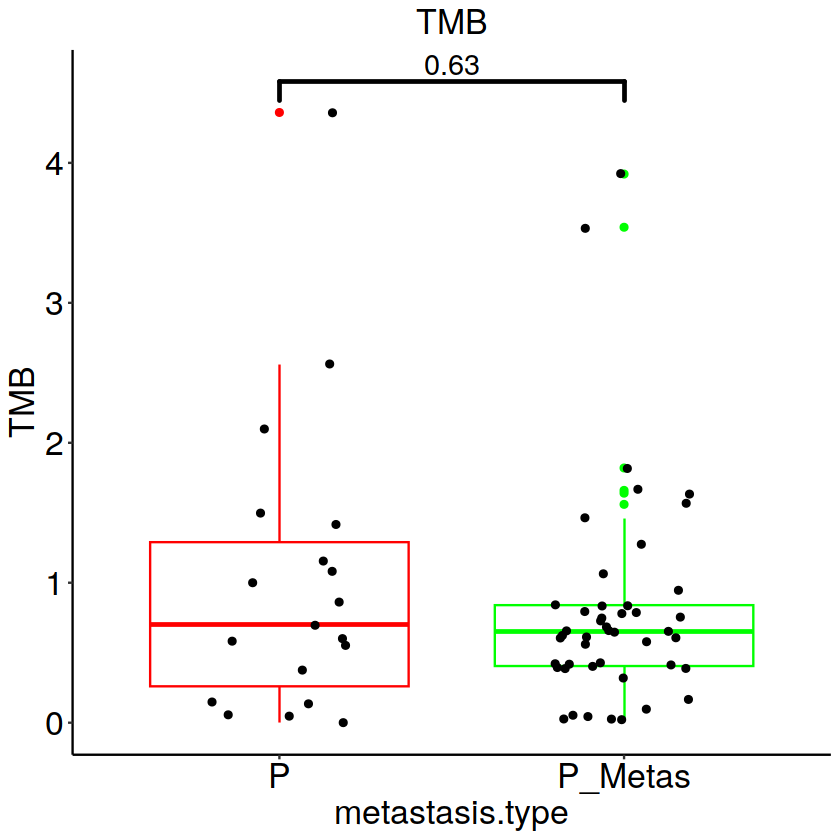

In [293]:

maf_P = maf_all[maf_all$Tumors.for.scRNA.seq.short=="P" & maf_all$histological.type.short=="adeno",]
maf_P = maf_P[maf_P$total<1000,]
# maf_P$metastasis.type[maf_P$metastasis.type=="P_LI"] = "P"
# maf_P$metastasis.type = factor(maf_P$metastasis.type,levels = c("P","P_LN","P_LM"))
library(ggpubr)
text_size = 20
# png("./summary/figures/TMB.png")
ggplot(maf_P,aes(x = metastasis.type,y = TMB))+geom_boxplot(color = c("red","green"))+ stat_compare_means(comparisons = list(
  c("P","P_Metas")
),method = "wilcox.test",bracket.size = 1,size = 6)+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))
# dev.off()



In [294]:
maf = maf_all[maf_all$total<1000,]

In [299]:
ggplot_list = list()

In [310]:

# maf$Clinical.stage = factor(maf$Clinical.stage,c("I","II","IIIA","IIIB","IVA","IVB"))
ggplot_list[[1]] = ggboxplot(maf, x = "Clinical.stage", y = "TMB",
               color = "Clinical.stage", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [306]:

ggplot_list[[2]] = ggboxplot(maf, x = "Tumors.for.scRNA.seq.short", y = "TMB",
               color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [307]:
ggplot_list[[3]] = ggboxplot(maf_all, x = "Clinical.stage", y = "cnv_count",
               color = "Clinical.stage", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [308]:
ggplot_list[[4]] = ggboxplot(maf_all, x = "Tumors.for.scRNA.seq.short", y = "cnv_count",
               color = "Tumors.for.scRNA.seq.short", palette = "jco",add = "jitter")+
stat_compare_means(method = "anova")+theme(axis.title.x = element_blank())+theme(legend.position="none")


In [313]:
pdf("./figures/TMB_cnv_count.pdf")
ggplot_list[[1]]+ggplot_list[[3]]+ggplot_list[[2]]+ggplot_list[[4]]
dev.off()

png 
  2

In [ ]:
png("./summary/figures/Purity.png")
ggplot(maf_P,aes(x = metastasis.type,y = Purity))+geom_boxplot(fill=scCancer::getDefaultColors(n=3))+ stat_compare_means(comparisons = list(
  c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
),method = "wilcox.test",bracket.size = 1,size = 6)+ggtitle("Purity")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))
dev.off()

### mutation between differnet MI_group

In [51]:
library(ggplot2)
library(ggpubr)

In [52]:
patient_group_5MI = readRDS("/home/wyh/scdata/combined_data/MI_group/patient_group_5MI.RDS")

In [54]:
patient_group_5MI$group = factor(patient_group_5MI$group)

In [55]:
patient_group_5MI_wes_plot = patient_group_5MI[intersect(rownames(maf),rownames(patient_group_5MI)),]

In [56]:
patient_group_5MI_wes_plot$cnv_count = maf[rownames(patient_group_5MI_wes_plot),"cnv_count"]

In [57]:
patient_group_5MI_wes_plot$TMB = sample_wes[rownames(patient_group_5MI_wes_plot),"TMB"]

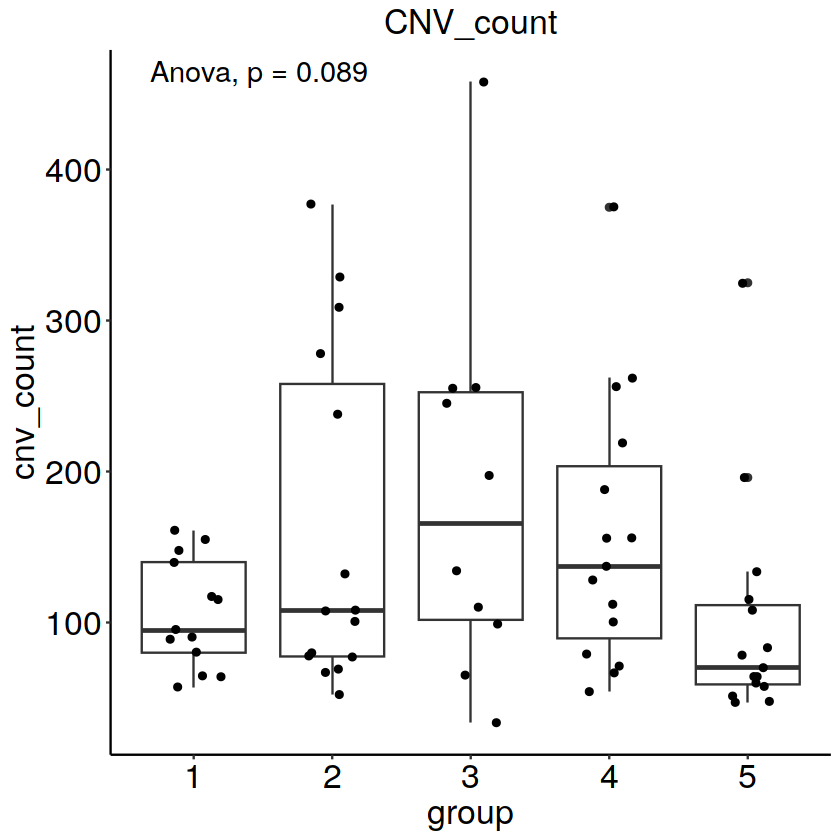

In [58]:
text_size = 20
ggplot(patient_group_5MI_wes_plot,aes(x = group,y = cnv_count))+geom_boxplot()+ stat_compare_means(method = "anova",bracket.size = 1,size = 6)+ggtitle("CNV_count")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))

In [60]:
patient_group_5MI_wes_plot_filter

,NewSample.ID,group,cnv_count,TMB
,<chr>,<fct>,<int>,<dbl>
GBC_002_P,GBC_002_P,4,262,1.42
GBC_003_P,GBC_003_P,2,78,0.60
GBC_004_P,GBC_004_P,4,219,0.38
GBC_006_P,GBC_006_P,1,117,0.64
GBC_007_P,GBC_007_P,1,148,0.42
GBC_008_P,GBC_008_P,5,60,2.10
GBC_009_P,GBC_009_P,2,67,0.78
GBC_010_P,GBC_010_P,5,64,0.66
GBC_011_P,GBC_011_P,1,57,0.66


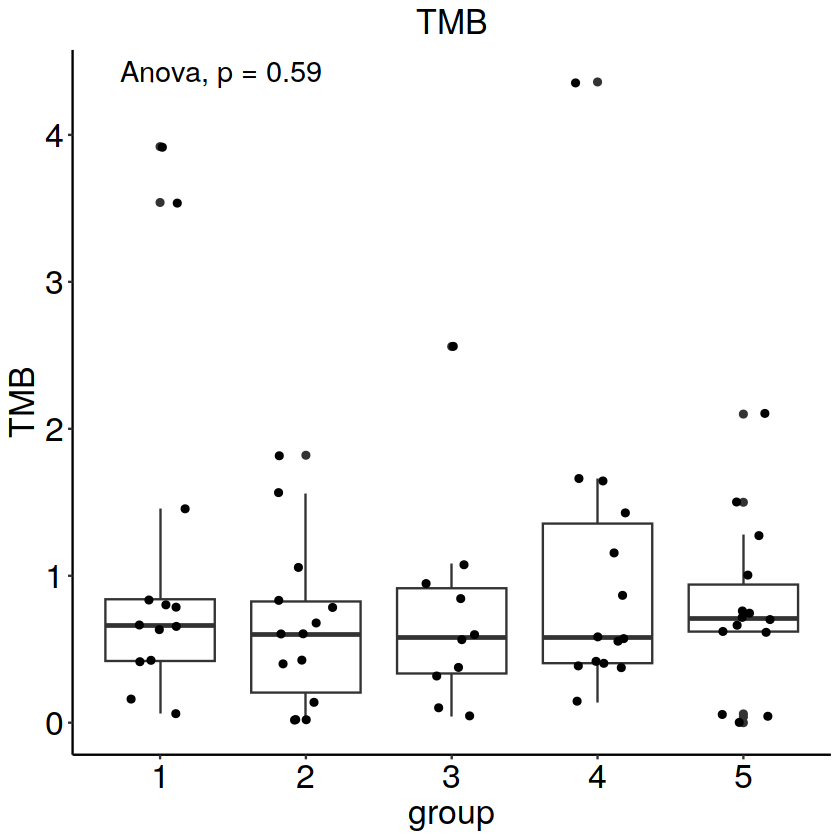

In [61]:
text_size = 20
ggplot(patient_group_5MI_wes_plot[patient_group_5MI_wes_plot$TMB<7.5,],aes(x = group,y = TMB))+geom_boxplot()+ stat_compare_means(method = "anova",bracket.size = 1,size = 6)+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))

### mutation rate between samples with different GM ratios

In [ ]:
# input：onco_matrix_P.txt，heatmap_GM_score.csv
# output： gene mutation rate with samples divided into two groups by average GM scores

In [47]:
library(ggplot2)

In [191]:
# matMut <- read.table("onco_matrix_P0725.txt", header = T, check.names = F, sep = "\t")

In [350]:
matMut = read.csv("./onco_matrix_P_filter.csv",row.names = 1)

In [351]:
# matMut <- read.table("onco_matrix_P0725.txt", header = T, check.names = F, sep = "\t")
# matMut$GBC_032_P = ""
matMut[matMut!=""] = 1
matMut[matMut==""] = 0

matMut_df = data.frame(matrix(ncol = 4, nrow = 0))
colnames(matMut_df) = c("gene","sample","value","metastasis.type")
iindex = 1
for(i in 1:nrow(matMut)){
  for(j in 1:ncol(matMut)){
    matMut_df[iindex,] = c(rownames(matMut)[i],colnames(matMut)[j],matMut[i,j],as.character(patient_info[colnames(matMut)[j],"metastasis.type"]))
    iindex = iindex + 1
  }
}
patient_num = as.data.frame.array(table(patient_info[colnames(matMut),"metastasis.type"]))[,1]
matMut_df = matMut_df[matMut_df$value==1,]

In [352]:
sample_data = read.csv("/home/wyh/scdata/combined_data/Epithelial//submit/figure_data/heatmap_GM_score.csv",row.names = 1)
sample_info =  data.frame(sample_name = colnames(matMut),row.names = colnames(matMut))

In [353]:
# Italics P 
# https://www.r-bloggers.com/2018/03/math-notation-for-r-plot-titles-expression-and-bquote/\
# https://www.statology.org/italics-in-r/

In [356]:
for(iGM in c(1,3,5,6,7,8,16)){
    sample_info['GM16_score'] = sample_data[sample_info$sample_name,paste0('score_GM',iGM)]
    sample_info['GM16_ratio'] = ifelse(sample_info[,"GM16_score"] >= median(sample_info[,"GM16_score"]),'High','Low')
    #sample_info['GM16_ratio'] = ifelse(sample_info[,"GM16_score"] >= quantile(sample_info[,"GM16_score"],2/3),'High','Median')
    #sample_info[sample_info[,"GM16_score"] <= quantile(sample_info[,"GM16_score"],1/3),'GM16_ratio'] = 'Low'
    patient_num = as.data.frame.array(table(sample_info$GM16_ratio))

    matMut_df = matMut_df[matMut_df$value==1,]
    matMut_df$GM16_ratio = sample_info[matMut_df$sample,"GM16_ratio"]
    #matMut_df = matMut_df[matMut_df$GM16_ratio!="Median",]
    GM16_mutation = as.data.frame.array(table(matMut_df[,c("gene","GM16_ratio")]))
    GM16_mutation$Low_ratio = round(GM16_mutation$Low/(patient_num[2,1]),3)
    GM16_mutation$Low_ratio_text = paste0(GM16_mutation$Low,"/",patient_num[2,1])
    GM16_mutation$High_ratio = round(GM16_mutation$High/patient_num[1,1],3)
    GM16_mutation$High_ratio_text = paste0(GM16_mutation$High,"/",patient_num[1,1])

    GM16_mutation$pvalue_greater = 0
    GM16_mutation$pvalue_less = 0
    GM16_mutation$pvalue = 0
    # patient_num = as.data.frame.array(table(sample_info$GM16_ratio))
    for(igene in rownames(GM16_mutation)){
      gene_matrix = matrix(c(GM16_mutation[igene,1],GM16_mutation[igene,2],patient_num[1,1]-GM16_mutation[igene,1],patient_num[2,1]-GM16_mutation[igene,2]),nrow = 2,
                           dimnames = list(c("High","Low"),c("mutate","Non-mutate")))
      gene_matrix = t(gene_matrix)
      GM16_mutation[igene,"pvalue_greater"] = round(fisher.test(gene_matrix,alternative = "greater")$p.value,3)
      GM16_mutation[igene,"pvalue_less"] = round(fisher.test(gene_matrix,alternative = "less")$p.value,3)
      GM16_mutation[igene,"pvalue"] = round(fisher.test(gene_matrix)$p.value,3)
    }

    gene_plot = rownames(GM16_mutation[order(GM16_mutation$pvalue),])[GM16_mutation[order(GM16_mutation$pvalue),]$pvalue<0.05]
    print(length(gene_plot))
    if(length(gene_plot)>0){
     pdf(paste0("./figures/GM",iGM,"_mutationV4.pdf"),height = 3.7,width = 2)
    for(igene in gene_plot){
        data_plot = data.frame(freq = t(GM16_mutation[igene,c('Low_ratio',"High_ratio")]),name = c("Low","High"))
        data_plot$por = t(GM16_mutation[igene,c("Low_ratio_text","High_ratio_text")])
        colnames(data_plot) = c("ratio","name","por_text")
        data_plot$name = factor(data_plot$name,levels = c("Low","High"))
        p<-ggplot(data=data_plot, aes(x=name, y=ratio)) +
        geom_bar(stat="identity", fill="steelblue")+
        theme_minimal()+geom_text(aes(label=por_text), vjust=-0.3, size=3.5)+theme_classic()+
        ggtitle(igene,subtitle = paste('P' , "= ", GM16_mutation[igene,"pvalue"]))+xlab(paste0("GM",iGM,"_score"))+ylab("Mutational Frequency")+
        theme(plot.title = element_text(hjust = 0.5))
    print(p)
    }
    dev.off()   
    }
  
}

[1] 0
[1] 2
[1] 0
[1] 0
[1] 0
[1] 1
[1] 0


### TMB and CNV count between different groups

In [115]:
laml = readRDS("./laml_filter_20_3_0015_005.RDS")
sample_wes = laml@variant.classification.summary
sample_wes = as.data.frame(sample_wes)
rownames(sample_wes) = sample_wes[,1]
sample_wes$TMB = sample_wes$total/50
write.csv(sample_wes,"./summary/wes_infoV3.csv")

,Tumor_Sample_Barcode,total,total_perMB,total_perMB_log
,<chr>,<dbl>,<dbl>,<dbl>
GBC_049_P,GBC_049_P,0,0.00,-Inf
GBC_032_P,GBC_032_P,1,0.02,-1.6989700
GBC_063_P,GBC_063_P,1,0.02,-1.6989700
GBC_078_P,GBC_078_P,1,0.02,-1.6989700
GBC_029_P,GBC_029_P,2,0.04,-1.3979400
GBC_052_P,GBC_052_P,2,0.04,-1.3979400
GBC_040_LN,GBC_040_LN,3,0.06,-1.2218487
GBC_050_P,GBC_050_P,3,0.06,-1.2218487
GBC_072_P,GBC_072_P,3,0.06,-1.2218487


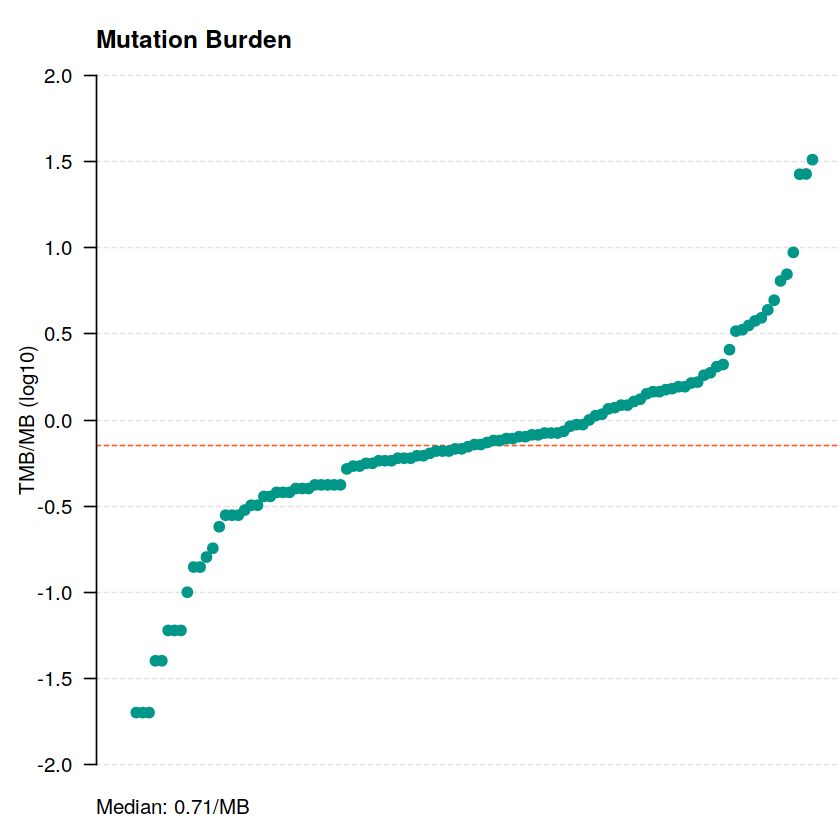

In [100]:
variants_number = tmb(maf = laml)
variants_number = as.data.frame(variants_number)
rownames(variants_number) = variants_number[,1]
variants_number

In [11]:
variants_sample_left = rownames(read.csv("./variants_number.csv",row.names = 1))

In [15]:
variants_number_left = variants_number[variants_sample_left,]

In [17]:
write.csv(variants_number_left,"./summary/variants_number_patient.csv")

In [370]:
sample_data = read.csv("/home/wyh/scdata/combined_data/Epithelial/submit/figure_data/heatmap_GM_score.csv",row.names = 1)

In [405]:
common_patient = intersect(rownames(sample_data),rownames(sample_wes))

In [406]:
common_patient = setdiff(commnon_patient,hyper_sample)

In [407]:
sample_info =  data.frame(sample_name = rownames(sample_data),row.names = rownames(sample_data))

sample_info['GM16_score'] = sample_data[sample_info$sample_name,'score_GM16']
sample_info = sample_info[common_patient,]
# sample_info['GM16_ratio'] = ifelse(sample_info[,"GM16_score"] >= median(sample_info[,"GM16_score"]),'High','Low')

In [408]:
sample_info$TMB = sample_wes[rownames(sample_info),"TMB"]
sample_info$metastasis.type = patient_info[rownames(sample_info),"metastasis.type"]
sample_info$progression.type.short = patient_info[rownames(sample_info),"progression.type.short"]

In [410]:
sample_info$metastasis.type[sample_info$metastasis.type=="P_LI"] = "P"
sample_info$metastasis.type[sample_info$metastasis.type %in% c("P_LN","P_LM")] = "P_Metas"

Warning message in wilcox.test.default(c(1.16, 0.7, 0.58, 4.36, 0.56, 0.86, 1.08, :
“cannot compute exact p-value with ties”


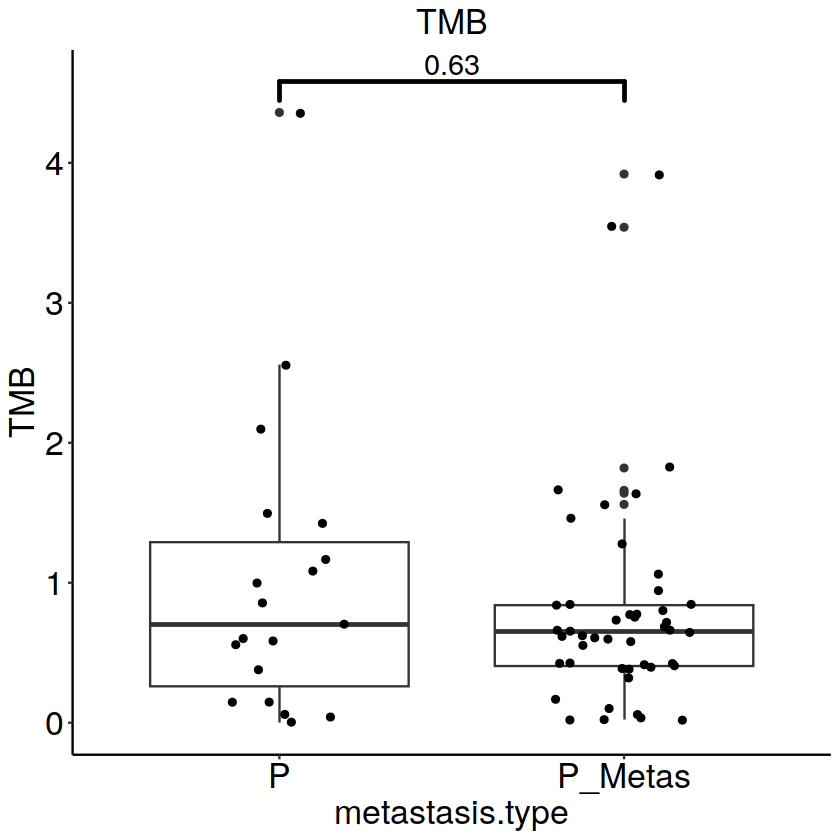

In [411]:
text_size = 20
ggplot(sample_info,aes(x = metastasis.type,y = TMB))+geom_boxplot()+ stat_compare_means(comparisons = list(
  c("P",'P_Metas')
),method = "wilcox.test",bracket.size = 1,size = 6)+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))

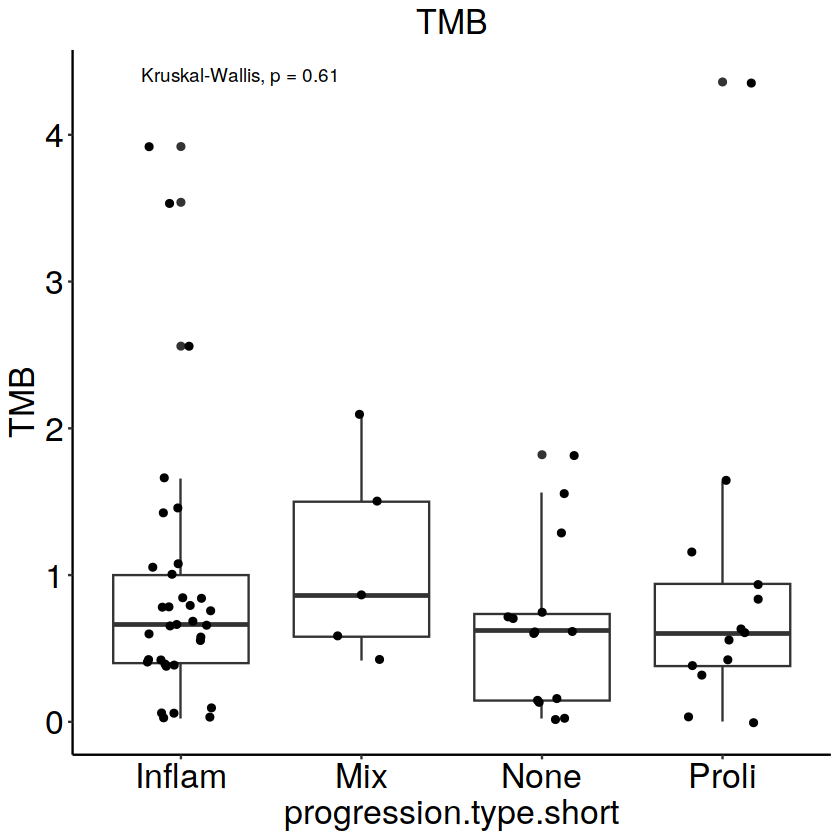

In [420]:
text_size = 20
ggplot(sample_info,aes(x = progression.type.short,y = TMB))+geom_boxplot()+ stat_compare_means()+ggtitle("TMB")+geom_jitter(width=0.2)+
  theme(panel.grid.major = element_blank(),panel.grid.minor = element_blank(),panel.background = element_blank(), 
                                               axis.line = element_line(colour = "black"),
                                               legend.position = "none",
                                               axis.text.x = element_text(color="black", size=text_size),
                                               axis.text.y = element_text(color="black", size=text_size),
                                               axis.title=element_text(size=text_size),
                                               legend.text=element_text(size=text_size),
                                               legend.title=element_text(size=text_size),
                                               plot.title =element_text(hjust = 0.5, size = 20))

In [413]:
data_plot = data.frame(GM16_score = sample_info[commnon_patient,"GM16_score"],TMB = sample_wes[commnon_patient,"TMB"])

In [415]:
data_plot = data.frame(GM16_score = sample_info[commnon_patient,"GM16_score"],TMB = sample_wes[commnon_patient,"TMB"])
data_plot = data_plot[data_plot$TMB<7.5,]
data_plot['GM16_ratio'] = ifelse(data_plot[,"GM16_score"] >= median(data_plot[,"GM16_score"]),'High','Low')


Warning message in wilcox.test.default(c(1.06, 0.78, 0.84, 0.4, 0.42, 0.66, 0.42, :
“cannot compute exact p-value with ties”


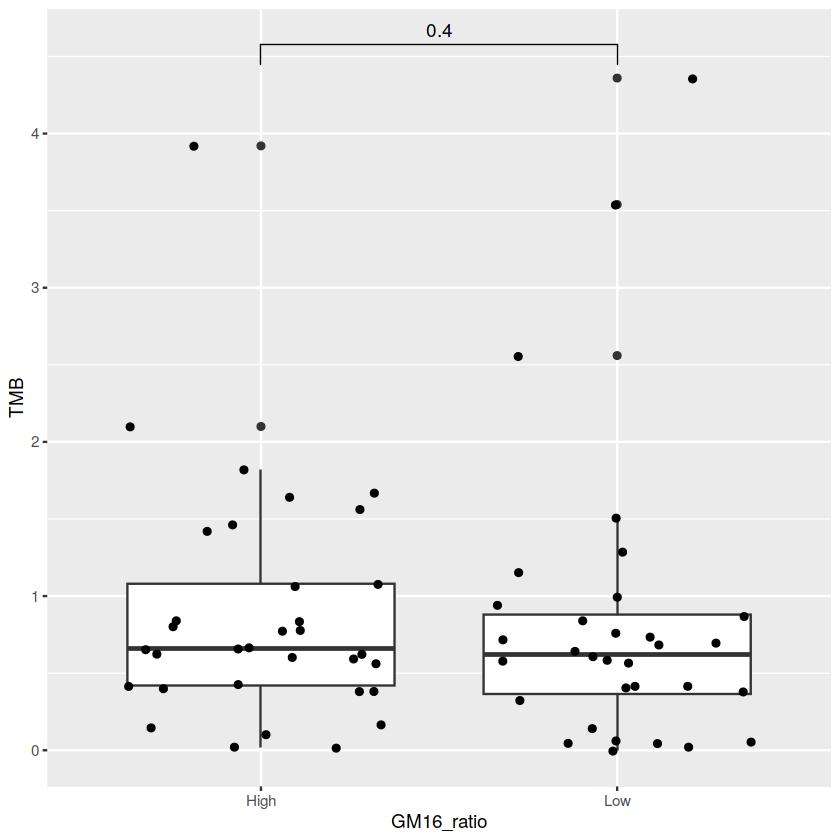

In [417]:
library(ggplot2)
library(ggpubr)
ggplot(data_plot, aes( y=TMB, x=GM16_ratio)) + geom_boxplot()+geom_jitter()+stat_compare_means(comparisons = list(
  c("High","Low")
),method = "wilcox.test")

In [381]:
cor.test(data_plot$GM16_score,data_plot$TMB)


	Pearson's product-moment correlation

data:  data_plot$GM16_score and data_plot$TMB
t = 0.37747, df = 63, p-value = 0.7071
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 -0.1986983  0.2880645
sample estimates:
       cor 
0.04750287 


## mutational signature

In [ ]:
# mutational signature ----------------------------------------------------
library(deconstructSigs)

hallmarks = read.csv("D:/postgraduate/database/msigdb/hallmarks.csv") 
mut = laml@data
mut = mut[mut$Variant_Type=="SNP",]
mut$NewSample.ID = mut$Tumor_Sample_Barcode
mut = merge(mut,patient_info)
mut_P = mut[mut$Tumors.for.scRNA.seq.short=="P" & mut$histological.type.short=="adeno",]
sigs.input <- mut.to.sigs.input(mut.ref = mut_P, 
                                sample.id = "Tumor_Sample_Barcode", 
                                chr = "Chromosome", 
                                pos = "Start_Position", 
                                ref = "Reference_Allele", 
                                alt = "Tumor_Seq_Allele2",
                                bsg = BSgenome.Hsapiens.UCSC.hg38::BSgenome.Hsapiens.UCSC.hg38)


w=lapply(unique(mut_P$Tumor_Sample_Barcode) , function(i){
  ## signatures.cosmic signatures.nature2013
  sample_1 = whichSignatures(tumor.ref = sigs.input[,], 
                             signatures.ref = signatures.cosmic, 
                             sample.id =  i, 
                             contexts.needed = TRUE,
                             tri.counts.method = 'default')
  print(i)
  return(sample_1$weights)
})
w=do.call(rbind,w)
library(pheatmap)
annotation_row = data.frame(row.names = rownames(w),metastasis.type = patient_info[rownames(w),"metastasis.type"])
annotation_col = annotation_col
pheatmap(t(w),cluster_rows = F,cluster_cols = T)
pheatmap(w,cluster_rows = T,cluster_cols = F,annotation_row = annotation_row)
mut.wt=w



w$metastasis.type = patient_info[rownames(w),"metastasis.type"]
somatic_signature_melt = reshape::melt(w[,c(21:27,28)])
colnames(somatic_signature_melt) = c("metastasis.type",'signature',"weight")
somatic_signature_melt$signature = gsub("Signature","Sig",x = somatic_signature_melt$signature)
somatic_signature_melt$metastasis.type[somatic_signature_melt$metastasis.type %in% c("P_LM","P_LN")] = "P_meta"


In [ ]:
### compare between different groups

In [ ]:
#pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast2.pdf",width = 15,height = 10)
library(ggplot2)
library(ggpubr)
print(ggplot(somatic_signature_melt, aes( y=weight, x=metastasis.type,fill = metastasis.type)) + geom_boxplot()+facet_grid(.~signature)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
              axis.text.y = element_text(color="black"),
              axis.title=element_text())+ggtitle("")+
        stat_compare_means(comparisons = list(
          c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
        ),method = "wilcox.test",label="p.signif")+ggtitle("mutation signature"))
#dev.off()


w$metastasis.type = patient_info[rownames(w),"metastasis.type"]
somatic_signature_melt = reshape::melt(w[,c(21:27,28)])
colnames(somatic_signature_melt) = c("metastasis.type",'signature',"weight")
somatic_signature_melt$signature = gsub("Signature","Sig",x = somatic_signature_melt$signature)
somatic_signature_melt$metastasis.type[somatic_signature_melt$metastasis.type %in% c("P_LM","P_LN")] = "P_meta"
#pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast2.pdf",width = 15,height = 10)
library(ggplot2)
library(ggpubr)
print(ggplot(somatic_signature_melt, aes( y=weight, x=metastasis.type,fill = metastasis.type)) + geom_boxplot()+facet_grid(.~signature)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
              axis.text.y = element_text(color="black"),
              axis.title=element_text())+ggtitle("")+
        stat_compare_means(comparisons = list(
          c("P","P_LN"),c("P","P_LM"),c("P_LN","P_LM")
        ),method = "wilcox.test",label="p.signif")+ggtitle("mutation signature"))
#dev.off()

somatic_signature_melt = reshape::melt(w)
colnames(somatic_signature_melt) = c("metastasis.type",'signature',"weight")
somatic_signature_melt$signature = gsub("Signature","Sig",x = somatic_signature_melt$signature)
somatic_signature_melt$metastasis.type = as.character(somatic_signature_melt$metastasis.type)
somatic_signature_melt$metastasis.type[somatic_signature_melt$metastasis.type %in% c("P_LM","P_LN")] = "P_meta"
#pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast2.pdf",width = 15,height = 10)
library(ggplot2)
library(ggpubr)
print(ggplot(somatic_signature_melt, aes( y=weight, x=metastasis.type,fill = metastasis.type)) + geom_boxplot()+facet_grid(.~signature)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
              axis.text.y = element_text(color="black"),
              axis.title=element_text())+ggtitle("")+
        stat_compare_means(comparisons = list(
          c("P","P_meta")
        ),method = "wilcox.test",label="p.signif")+ggtitle("mutation signature"))
#dev.off()

### establish relationship with GM16

In [ ]:
w = w[,1:30]
w$GM16_ratio = sample_info[rownames(w),"GM16_ratio"]
somatic_signature_melt = reshape::melt(w)
colnames(somatic_signature_melt) = c("GM16_ratio",'signature',"weight")
somatic_signature_melt$signature = gsub("Signature","Sig",x = somatic_signature_melt$signature)
somatic_signature_melt$GM16_ratio = as.character(somatic_signature_melt$GM16_ratio)

#pdf("/home/wyh/scdata/combined_data//fibroblast/group_compare/fibroblast2.pdf",width = 15,height = 10)
library(ggplot2)
library(ggpubr)
print(ggplot(somatic_signature_melt, aes( y=weight, x=GM16_ratio,fill = GM16_ratio)) + geom_boxplot()+facet_grid(.~signature)+
        theme(axis.text.x = element_text(angle = 45, hjust = 1, vjust = 1,color="black"),
              axis.text.y = element_text(color="black"),
              axis.title=element_text())+ggtitle("")+
        stat_compare_means(comparisons = list(
          c("High","Low")
        ),method = "wilcox.test",label="p.signif")+ggtitle("mutation signature"))
#dev.off()




save(mut.wt,file = './summary/signatures.cosmic.Rdata')

w_signatures.cosmic = readRDS("./summary/signatures.cosmic.RDS")

In [ ]:
# https://indrajeetpatil.github.io/ggstatsplot/reference/ggbarstats.html

# BiocManager::install("ggstatsplot")
# library(ggstatsplot)
# p <- ggbarstats(mtcars, x = vs, y = cyl)
# p

# CNV analysis

## CNV plot

In [ ]:
vi filenames.txt
:set fileformat=unix
:wq
cat -v filenames.txt
/home/glab/huqf/3D2/WEStools/cnvkit/cnvkit.py heatmap `cat filenames.txt` -o /home/glab/wuyh/GBC/WES/GBC_WES_ALL/cnv/heatmap_cnvkit2.png

## GISTIC 

In [252]:
setwd("/home/wyh/scdata/WES/")

In [253]:
file_name = read.csv("./file_rename.csv",row.names = 1)[,2]

### data preparation

In [367]:
seg_file = readRDS("./cnvkit/absolute/seg_file.RDS")
segmentationfileV2 =  Reduce(rbind, seg_file)
dim(segmentationfileV2)
colnames(segmentationfileV2) = c("chrom","loc.start","loc.end",'num.mark','seg.mean',"ID") 
segmentationfileV2 = segmentationfileV2[,c("ID","chrom","loc.start","loc.end","num.mark","seg.mean")]
write.table(segmentationfileV2,"./gistic2/GBC/segmentationfileV2.txt",sep = "\t",quote = FALSE,row.names = FALSE)

In [66]:
segmentationfileV2 = read.csv("./gistic2/GBC/segmentationfileV2.txt",sep = "\t")

In [68]:
segmentationfile = read.csv("./gistic2/GBC/segmentationfile.txt",sep = "\t")

In [16]:
patient_info = read.csv("/home/wyh/scdata/patient_info/xzh_220109_final_wyh_220426.csv",row.names = 1)

In [17]:
patient_info$metastasis.type[patient_info$metastasis.type=="P_LI"] = "P"
patient_info$metastasis.type = factor(patient_info$metastasis.type,levels = c("P","P_LN","P_LM"))

In [18]:
head(patient_info)

,Sample.ID,NewSample.ID,Tumors.for.scRNA.seq,Sex,Age,TNM,Clinical.stage,histological.type,Differentiation,CA.19.9..U.ml.,⋯,Adenomyomatosis,XGC,chronic.cholecystitis,Tumors.for.scRNA.seq.unify,histological.type.short,patient.index,Tumors.for.scRNA.seq.short,metastasis.type,progression.type,progression.type.short
,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<fct>,<chr>,<chr>
GBC_001_LI,GBC1,GBC_001_LI,liver invasion,M,67,T4NxM1,IVB,adenocarcinoma,Moderate,>1000,⋯,NA,NA,NA,Liver invasion,adeno,237090,LI,NA,Inflammatory,Inflam
GBC_002_P,GBC2,GBC_002_P,Primary,F,85,T2bN0M0,IIB,adenocarcinoma,Moderate,Negative,⋯,NA,NA,NA,Primary,adeno,365687,P,P,Inflammatory,Inflam
GBC_003_P,GBC3,GBC_003_P,Primary,F,71,T4NxM0,IVA,adenocarcinoma,Moderate,57.38,⋯,NA,NA,NA,Primary,adeno,365672,P,P_LN,Proliferative,Proli
GBC_004_P,GBC4,GBC_004_P,Primary,M,71,T3N1M1,IVB,adenocarcinoma,Poor,386,⋯,NA,NA,NA,Primary,adeno,237543,P,P_LM,Inflammatory,Inflam
GBC_005_P,GBC5,GBC_005_P,Primary,M,68,T4NxM0,IVA,adenosquamous carcinoma,Poor,Negative,⋯,NA,NA,NA,Primary,adeno squa,237456,P,P_LN,Inflammatory,Inflam
GBC_006_P,GBC6,GBC_006_P,Primary,M,59,T4N1M0,IVA,adenocarcinoma,Moderate,61.09,⋯,NA,NA,NA,Primary,adeno,365681,P,P_LN,Proliferative,Proli


In [330]:
wes_patient_info  = patient_info[file_name,]

In [331]:
wes_patient_info_P =  wes_patient_info[wes_patient_info$Tumors.for.scRNA.seq.short=="P",]

In [332]:
table(wes_patient_info_P$metastasis.type)


   P P_LI P_LM P_LN 
  16    5   12   46 

In [333]:
table(wes_patient_info_P$progression.type.short)


Inflam    Mix   None  Proli 
    37      5     20     17 

In [334]:
for(itype in unique(wes_patient_info_P$metastasis.type)){
    segmentationfile_new = segmentationfile[segmentationfile$ID %in% wes_patient_info_P$NewSample.ID[wes_patient_info_P$metastasis.type==itype],]
    write.table(segmentationfile_new,paste0("/home/wyh/scdata/WES/gistic2/GBC_metastasis.type/segmentationfile_",itype,".txt"),sep = "\t",quote = FALSE,row.names = FALSE)
}

In [26]:
for(itype in unique(wes_patient_info_P$progression.type.short)){
    segmentationfile_new = segmentationfile[segmentationfile$ID %in% wes_patient_info_P$NewSample.ID[wes_patient_info_P$progression.type.short==itype],]
    write.table(segmentationfile_new,paste0("/home/wyh/scdata/WES/gistic2/GBC_progression.type.short/segmentationfile_",itype,".txt"),sep = "\t",quote = FALSE,row.names = FALSE)
}

In [27]:
for(itype in unique(wes_patient_info$Tumors.for.scRNA.seq.short)){
    segmentationfile_new = segmentationfile[segmentationfile$ID %in% wes_patient_info$NewSample.ID[wes_patient_info$Tumors.for.scRNA.seq.short==itype],]
    write.table(segmentationfile_new,paste0("/home/wyh/scdata/WES/gistic2/GBC_Tumors.for.scRNA.seq.short/segmentationfile_",itype,".txt"),sep = "\t",quote = FALSE,row.names = FALSE)
}

### plot

-Processing Gistic files..
--Processing amp_genes.conf_90.txt
--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples
-Processing Gistic files..
--Processing amp_genes.conf_90.txt
--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples
-Processing Gistic files..
--Processing amp_genes.conf_90.txt


Warning message in data.table::fread(input = gisticAmpGenesFile, stringsAsFactors = FALSE, :
“Discarded single-line footer: <<genes in wide peak>>”


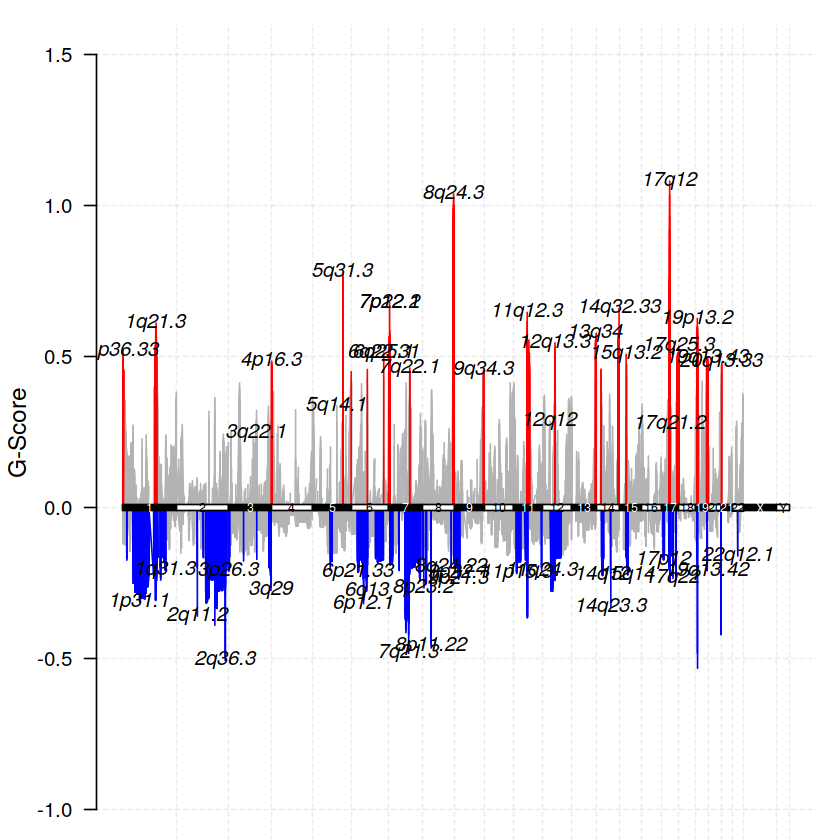

--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples


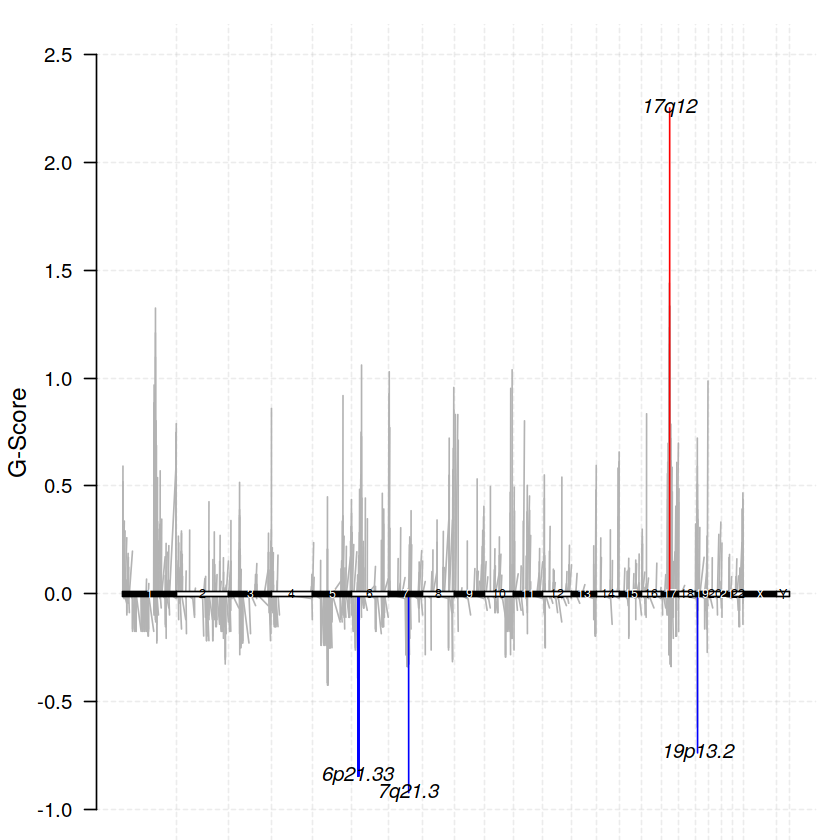

-Processing Gistic files..
--Processing amp_genes.conf_90.txt
--Processing del_genes.conf_90.txt
--Processing scores.gistic
--Summarizing by samples


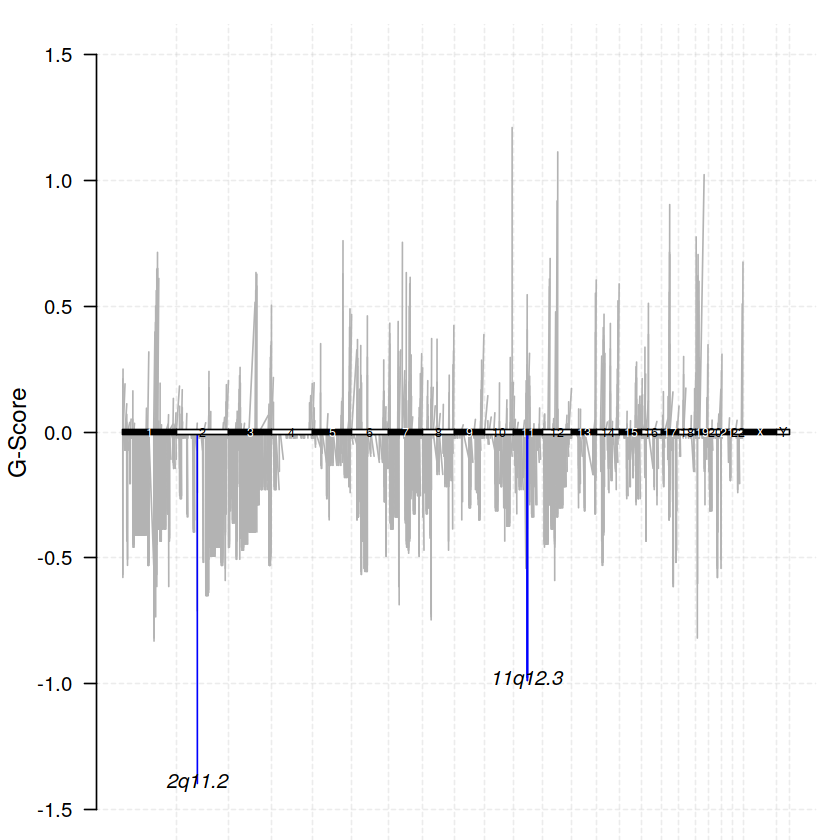

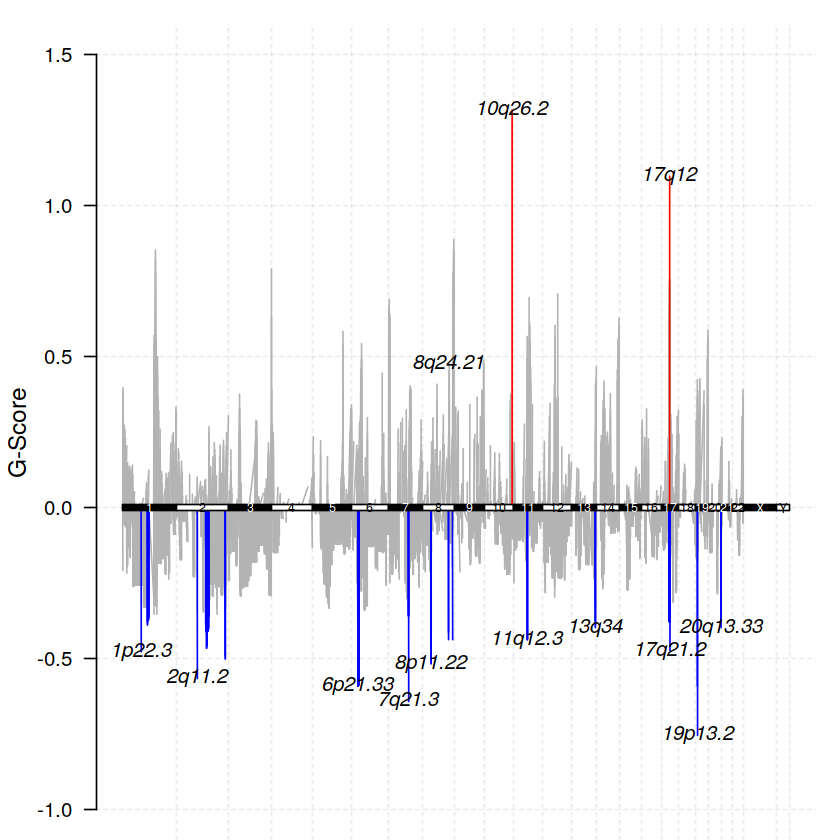

In [251]:
laml.gistic_list = list()
cytoband1_list = list()
for(itype in c(c("P","LI","LN","Metas"))){
  all.lesions = paste0(getwd(),"/gistic2/GBC_Tumors.for.scRNA.seq.short/GBC_",itype,"/","all_lesions.conf_90.txt")
  amp.genes = paste0(getwd(),"/gistic2/GBC_Tumors.for.scRNA.seq.short/GBC_",itype,"/","amp_genes.conf_90.txt")
  del.genes = paste0(getwd(),"/gistic2/GBC_Tumors.for.scRNA.seq.short/GBC_",itype,"/","del_genes.conf_90.txt")
  scores.gis = paste0(getwd(),"/gistic2/GBC_Tumors.for.scRNA.seq.short/GBC_",itype,"/","scores.gistic")
  laml.gistic = readGistic(gisticAllLesionsFile = all.lesions, gisticAmpGenesFile = amp.genes, gisticDelGenesFile = del.genes, gisticScoresFile = scores.gis, isTCGA = TRUE)
  saveRDS(laml.gistic,paste0("./gistic2/GBC_Tumors.for.scRNA.seq.short/GBC_",itype,"/laml.gistic.RDS"))
  gisticChromPlot(gistic = laml.gistic, markBands = "all",fdrCutOff = 0.01,txtSize = 1)
  laml.gistic_list = c(laml.gistic_list,laml.gistic)
  cytoband1 = laml.gistic@cytoband.summary
  cytoband1 = cytoband1[cytoband1$qvalues<0.01,]
  cytoband1_list[[itype]] = cytoband1
}
saveRDS(laml.gistic_list,"./gistic2/GBC_Tumors.for.scRNA.seq.short/laml.gistic_list_Tumors.type.RDS")
saveRDS(cytoband1_list,"./gistic2/GBC_Tumors.for.scRNA.seq.short/cytoband1_list_Tumors.type.RDS")

In [239]:

laml.gistic_list = readRDS("./output/GBC_Tumors.for.scRNA.seq.short/laml.gistic_list_Tumors.type.RDS")

pdf("./output/GBC_Tumors.for.scRNA.seq.short/figures/P.pdf",height = 10,width = 10)
gisticChromPlot(gistic = laml.gistic_list[[1]], markBands = "all",fdrCutOff = 0.0001,txtSize = 0.7)
dev.off()
pdf("./output/GBC_Tumors.for.scRNA.seq.short/figures/P_LNV2.pdf",height = 3,width = 3)
gisticChromPlot(gistic = laml.gistic_list[[2]], markBands = "all",fdrCutOff = 0.01,txtSize = 1)
dev.off()
pdf("./output/GBC_Tumors.for.scRNA.seq.short/figures/P_LM.pdf",height = 3,width = 3)
gisticChromPlot(gistic = laml.gistic_list[[3]], markBands = "all",fdrCutOff = 0.01,txtSize = 1)
dev.off()

pdf("./output/GBC_Tumors.for.scRNA.seq.short/figures/P_Metas.pdf",height = 10,width = 10)
gisticChromPlot(gistic = laml.gistic_list[[4]], markBands = "all",fdrCutOff = 0.0001,txtSize = 1)
dev.off()